https://www.kaggle.com/muzzzdy/sms-spam-detection-with-various-classifiers

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [0]:
import numpy as np

In [1]:

from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###data examination

In [2]:
%cd "/content/drive/My Drive"
!ls

/content/drive/My Drive
 1.jpg				'Colab Notebooks'
 30Jandata			'dataset 2019.11.25'
 3.jpg				 generateData.m
 baseFunc.m			 papers
'case13-Dec-2019 15.18.07.mat'	'Rovit Dataset.zip'
'case13-Dec-2019 15.18.50.mat'	 spam.csv
'case13-Dec-2019 15.21.04.mat'	 StackGAN.pdf
'case13-Dec-2019 15.21.22.mat'	 StackGAN++.pdf
'case13-Dec-2019 15.21.44.mat'


In [3]:
import pandas

mydata = pandas.read_csv("spam.csv",encoding="latin-1")

mydata.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


ham     0.865937
spam    0.134063
Name: label, dtype: float64

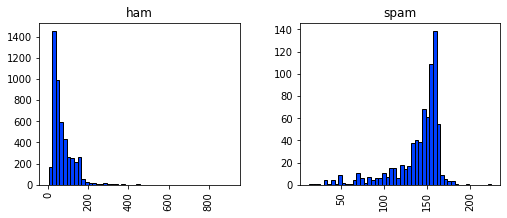

In [4]:
mydata = mydata.drop(labels=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)


mydata = mydata.rename(columns = {"v1":"label","v2":"inp"})
mydata.describe()

mydata["length"] = mydata["inp"].apply(len)
mydata.head()

import matplotlib as mat

mat.rcParams["patch.force_edgecolor"] = True
mat.pyplot.style.use("seaborn-bright")
mydata.hist(column="length",by="label",bins=50,figsize=(8,3))


mydata['label'] = mydata['label'].astype('category')
mydata['label'].cat.codes.corr(mydata['length'])


mydata['label'].value_counts()/mydata.shape[0]


### preprocessing

In [0]:
import string

def text_process(text):
  text = text.translate(str.maketrans('','',string.punctuation))
  text = [word.lower() for word in text.split()]

  return " ".join(text)


In [6]:
inpcol = mydata['inp'].copy()
preprocessed = inpcol.apply(text_process)
preprocessed[0]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

In [7]:
maxlen = 0 
for document in preprocessed:
  document_len = len(document.split())
  if document_len>maxlen:
    maxlen = document_len

print(maxlen)
print(document.split())

171
['rofl', 'its', 'true', 'to', 'its', 'name']


In [8]:
from keras.preprocessing.text import one_hot

vocab_size = 20000
encoded_docs =  [one_hot(document,vocab_size) for document in preprocessed]
print(encoded_docs[0])


Using TensorFlow backend.


[7067, 5184, 2093, 9347, 6679, 13673, 4774, 4963, 6367, 608, 16674, 4491, 7325, 5885, 19574, 6185, 18255, 5200, 16653, 10764]


In [11]:
from keras.preprocessing.sequence import pad_sequences

padded_docs = pad_sequences(encoded_docs,maxlen=maxlen, padding = 'post')
print(padded_docs)
print(np.shape(padded_docs))

mydata2 = []


for i in range(len(mydata)):
  myex = [None,None]
  myex[0] = padded_docs[i]

  if mydata.loc[i][0] == 'ham':
    myex[1] = 0
  elif mydata.loc[i][0] == 'spam':
    myex[1] = 1
  
  mydata2.append(myex)

  


[[ 7067  5184  2093 ...     0     0     0]
 [ 1560  5515  4376 ...     0     0     0]
 [ 9510 19802  4963 ...     0     0     0]
 ...
 [ 3898 15640  4963 ...     0     0     0]
 [10801 11010  5501 ...     0     0     0]
 [ 9980  6965  3381 ...     0     0     0]]
(5572, 171)


In [12]:
print(np.shape(mydata2))
print(mydata2[0])

(5572, 2)
[array([ 7067,  5184,  2093,  9347,  6679, 13673,  4774,  4963,  6367,
         608, 16674,  4491,  7325,  5885, 19574,  6185, 18255,  5200,
       16653, 10764,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
         

###Network

In [18]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(padded_docs[:],
                                                np.array(mydata2)[:,1],
                                                test_size = 0.3,
                                                random_state = 22)
print(np.shape(xtrain),np.shape(ytrain))

(3900, 171) (3900,)


In [17]:
xtrain[0]

array([ 3595, 15663,  5605,  7057, 10801,  8788,  7045, 14207, 12618,
        3198, 16840, 10806,  7045,  7067,  3568, 18115,  7936,  6497,
        7660,  2979, 16840, 10801,  5004,  7025,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
#from keras.optimizers import Adam
#myopt = Adam(lr=0.00001)

In [34]:
from keras.layers import LSTM, BatchNormalization, Dropout, Input, Dense, Embedding, Flatten
from keras.models import Sequential




model = Sequential()

model.add(Embedding(vocab_size, 512,input_length=maxlen))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.fit(xtrain,ytrain,epochs=100,batch_size=128,validation_split=0.3)


Train on 2730 samples, validate on 1170 samples
Epoch 1/100
2730/2730 [==============================] - 2s 648us/step - loss: 2.1235 - acc: 0.8623 - val_loss: 2.0393 - val_acc: 0.8735
Epoch 2/100
2730/2730 [==============================] - 1s 234us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0392 - val_acc: 0.8735
Epoch 3/100
2730/2730 [==============================] - 1s 234us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0391 - val_acc: 0.8735
Epoch 4/100
2730/2730 [==============================] - 1s 232us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0391 - val_acc: 0.8735
Epoch 5/100
2730/2730 [==============================] - 1s 233us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0391 - val_acc: 0.8735
Epoch 6/100
2730/2730 [==============================] - 1s 238us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0391 - val_acc: 0.8735
Epoch 7/100
2730/2730 [==============================] - 1s 232us/step - loss: 2.2199 - acc: 0.8623 - val_loss: 2.0391 - val_acc: 

KeyboardInterrupt: ignored